In [87]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import librosa
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torchaudio
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, f1_score
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from IPython.display import Audio
import random
from sklearn.linear_model import LogisticRegression
import time

In [88]:
path_train = './audios_train'
path_test = './audios_test'  
path_valid = './audios_valid'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metrics__ = ["loss", "accuracy", "precision", "recall", "f1"]

In [89]:
def show_spectrs(listFiles):
    params = {
        "channel": 0,
        "dither": 0.0,
        "window_type": "hanning",
        "frame_length": 6.25,
        "frame_shift": 3.125,
        "remove_dc_offset": False,
        "round_to_power_of_two": False,
        "sample_frequency": 48000
    }
    nrows = len(listFiles) // 4 + (len(listFiles) % 4 > 0)
    fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(30, 15))
    for i, file in enumerate(listFiles):
        waveform, _ = torchaudio.load(file)
        mfcc = torchaudio.compliance.kaldi.mfcc(waveform, **params).T
        label = file.split('\\')[-1]
        el = axs[i // 4, i % 4].imshow(mfcc, interpolation="nearest", origin="lower", aspect="auto")
        axs[i // 4, i % 4].set_title(f"File name: {label}")

    fig.colorbar(el, ax=axs, location='right')
    plt.show()

def show_diagramm(listFiles):
    nrows = len(listFiles) // 4 + (len(listFiles) % 4 > 0)
    _, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(30, 15))

    for i, path in enumerate(listFiles):
        waveform, sample_rate = torchaudio.load(path)
        waveform = waveform.numpy()
        name = path.split('\\')[-1]
        time = [i / sample_rate for i in range(waveform.shape[1])]
        axs[i // 4, i % 4].plot(time, waveform[0])
        axs[i // 4, i % 4].set_title(f"{name}")
    plt.show()

def show_audio(listFiles):
    for path in listFiles:
        display(Audio(path))

def select_files(path, count, random_=False):
    listFiles = [os.path.join(path, i) for i in os.listdir(path)]
    if random_:
        selectFiles = random.sample(listFiles, count)
    else:
        selectFiles = listFiles[:count]
    return selectFiles

def barplot(path, figsize=(20,3), fnt_x=20,
             title="Количественное представление"):
    files = np.array([file.split('-')[-1].replace('.wav', '') for file in os.listdir(path)])
    labels, counts = np.unique(files, return_counts=True)
    cmap = sns.color_palette("light:#5A9", as_cmap=True)
    plt.figure(figsize=figsize)
    sns.barplot(x=labels, y=counts, palette="dark");
    plt.xticks(rotation = 'vertical', fontsize=fnt_x);
    plt.xlabel("Звук_нормальный/с ошибкой", fontsize=20)
    plt.ylabel("Количество\nфайлов", fontsize=20)
    plt.title(title, fontsize=25)
    plt.show()

def get_metrics(y_true, y_pred, average="weighted", zero_division=0):
    y_true, y_pred = y_true.cpu(), y_pred.cpu()
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred,
                              average=average, zero_division=zero_division)
    recall = recall_score(y_true, y_pred,
                        average=average, zero_division=zero_division)
    f1 = f1_score(y_true, y_pred,
                average=average, zero_division=zero_division)
    return acc, precision, recall, f1

def train(model, train_dl, optimizer, criterion):
    model.train()
    train_loss = 0
    y_true = torch.empty(0, dtype=torch.long).to(device)
    y_pred = torch.empty(0, dtype=torch.float).to(device)

    for inputs, targets in tqdm(train_dl, leave=False, desc='train'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        pred_ = torch.max(outputs, 1)[1]
        y_true = torch.cat((y_true, targets))
        y_pred = torch.cat((y_pred, pred_))

    return y_true, y_pred, train_loss

def test(model, test_dl, criterion):
    model.eval()
    test_loss = 0
    y_true = torch.empty(0, dtype=torch.long).to(device)
    y_pred = torch.empty(0, dtype=torch.float).to(device)
    with torch.no_grad():
        for inputs, targets in tqdm(test_dl, leave=False, desc='test'):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            pred_ = torch.max(outputs, 1)[1]
            y_true = torch.cat((y_true, targets))
            y_pred = torch.cat((y_pred, pred_))

    return y_true, y_pred, test_loss

def results_df(params=None):
    return pd.DataFrame(
        data=params,
        columns=["epoch", "type", *metrics__],
    ).set_index(["epoch", "type"])


def train_model(model, train_dl, validation_dl, optimizer, criterion, num_epochs=10,
                patience=2, early_stopping=3, factor=0.2):
    start = time.time()
    results = results_df()
    previous = 9999999999
    best_epoch = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=patience, factor=factor,
        verbose=True, min_lr=0.000001)
    
    for epoch in range(num_epochs):
        y_true, y_pred, train_loss = train(model, train_dl, optimizer, criterion)
        
        temp = [[epoch, "train", train_loss, *get_metrics(y_true, y_pred)]]
        results = pd.concat((results, results_df(temp)))
        
        y_true, y_pred, validation_loss = test(model, validation_dl, criterion)
        
        temp = [[epoch, "validation", validation_loss, *get_metrics(y_true, y_pred)]]
        results = pd.concat((results, results_df(temp)))
        
        val_acc = results.loc[(epoch, 'validation'), 'accuracy']
        if previous-validation_loss > 0.001:
            previous = validation_loss
            best_epoch = epoch
        elif epoch - best_epoch > early_stopping:
            break
                
        scheduler.step(validation_loss)
        print(f"\r#Эпоха [{epoch+1:2}]: train loss [{train_loss:.4f}],",
              f"validation loss [{validation_loss:.4f}],",
              f"train accuracy [{results.loc[(epoch, 'train'), 'accuracy']:.4f}],",
              f"validation accuracy [{val_acc:.4f}]")
    print("Время обучения: ", time.time() - start, "секунд")
    return results


def plot_metric(result_df, type_="loss", ax_flag=None,
                figsize=(14,5), fontsize=16, show_ylabel=True,
                title=False, show_xlabel=True, twinx=False):
    if not ax_flag:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = ax_flag
    xs = pd.IndexSlice
    plt1, = ax.plot(
        result_df.loc[xs[:,"train"]].values,
        label=f"train {type_}",
        color="#F3A505",
        linewidth = 3)
    if twinx:
        ax2 = ax.twinx()
    else:
        ax2 = ax
    plt2, = ax2.plot(
        result_df.loc[xs[:,"validation"]].values,
        label=f"validation {type_}",
        color="#2E8B57",
        linewidth = 3)
    if title:
        ax.set_title(type_)
    ax.legend(handles=[plt1, plt2], fontsize=fontsize)
    
    if show_xlabel:
        ax.set_xlabel("Номер эпохи", fontsize=fontsize)
    if show_ylabel:
        ax.set_ylabel(type_, fontsize=fontsize, rotation=90)
    ax.grid(which="both", color="#d0d0d0", linestyle="dashed")
    if not ax_flag:
        plt.show()
        
def plot_metrics(result_df, figsize=(18,10), fontsize=10, title=True):
    fig, ax = plt.subplots(figsize=figsize, nrows=3, ncols=2, sharex=True)
    ax = [axij for axi in ax for axij in axi]
    ax[-1].remove()
    for i, type_ in enumerate(metrics__):     
        plot_metric(result_df[type_], type_=type_, ax_flag=ax[i], show_xlabel=False,
                    fontsize=fontsize, show_ylabel=False, title=True, twinx=False)
    
def heatmap_(y_true, y_pred, classes, fontsize=12, figsize=(14,10)):
    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap='Greens');
    x = np.unique(y_true).astype("int")
    x.sort()
    classes = np.array(classes)[x]
    heatmap.set_yticklabels(classes, rotation = 0, fontsize = fontsize)
    heatmap.set_xticklabels(classes, rotation =90, fontsize = fontsize);
    plt.show()
    

#### 1. Выбрать (собрать) набор данных для анализа в соответствии с выбранной темой курсовой работы. Описать этот набор и решаемую задачу. Определить метрики качества для модели, определить типичный уровень метрик для решения аналогичных задач, установить ориентиры для метрики.

Для решения задачи, определения наличия ошибки в звукопроизношении, был создан набор данных из аудиофайлов формата wav, которые включают в себя по 1 слову и имеют частоту дискретизации 48000. Всего используется 11 слов, по 3 на звуки Л, Р, Ш и 2 на звук Ж. Каждое слово соответствует наличию определенного звука в 3-х позициях (начало, середина и конец), звук Ж всегда оглушается на Ш в конце слова по этому данная позиция звука не проверяется. Всего представленно 3 набора данных: обучающая (4400), тренировочная (2200) и проверочная (2200). 

Решения аналогичных задач найденно небыло, другие задачи по анализу звукового потока были нацелены на классификации по музыкальным жанрам или животным, что позволяло брать спектрограмму звука и классифицировать по уровню сигнала (например в классической музыке уровень сигнала минимальный, в то время как для рока он большой).

Так как в нашем датасете имееется несколько слов на 1 звук, то перед нами стоит 2 цели:
1) модель должная определять принадлежность слова к звуку
2) модель должна определить наличие ошибки в звук

По этому основной метрикой будет выступать точность предсказаний. Также будем использовать precision, recall, f1 score. Ориентироваться будем на точность в 85%+, эту цифру я получил использя `LogisticRegression` (пример реализации будет представлен в самом конце) и это я считаю хорошим результатом т.к. в датасете используются звуки Р (который может заменятся на Л. Пример рыба) и Ж (который может заменятся на Ш. Пример жаба), помимо этого есть погрешность (артефакты, ударения) в алгоритме генерации (она минимальная, но имеется), которые можно выявить только прослушиванием каждого файла, что займет большое количество времени. 

Для последующих примеров - буду загружать файлы напрямую

In [90]:
selectFiles = select_files(path_train, 8, True)

#### 2. Провести предварительный анализ и очистку данных. Этот этап включает в себя вывод информации о количественных характеристиках датасета, информацию об отсутствующих значениях, характеристиках и физическом смысле каждого атрибута данных, его значимости для предсказания целевой переменной, вывод нескольких элементов данных для иллюстрации структуры данных.

Предварительная очистка данных не нужна, т.к. все данные сгенерированны и исключают ошибки. Но необходимо выполнить преобразование к одному размеру, для этого используем `pad`, который дополняет нулями или обрезает звуковую волну. После чего необходимо получить MFCC полученной волны.

Предсказание хранится в названии файла в виде "*звук_norm/err*", где norm - произношение без ошибки, err - с ошибкой

Пример аудиофайлов, которые мы используем без предварительной обработки

In [91]:
show_audio(selectFiles)

Пример звуковой волны выбранных файлов, волны в начале и конце являются артефактами, но очищать от них нет необходимости, т.к. вся основная энергия сконцентрированна в середине.

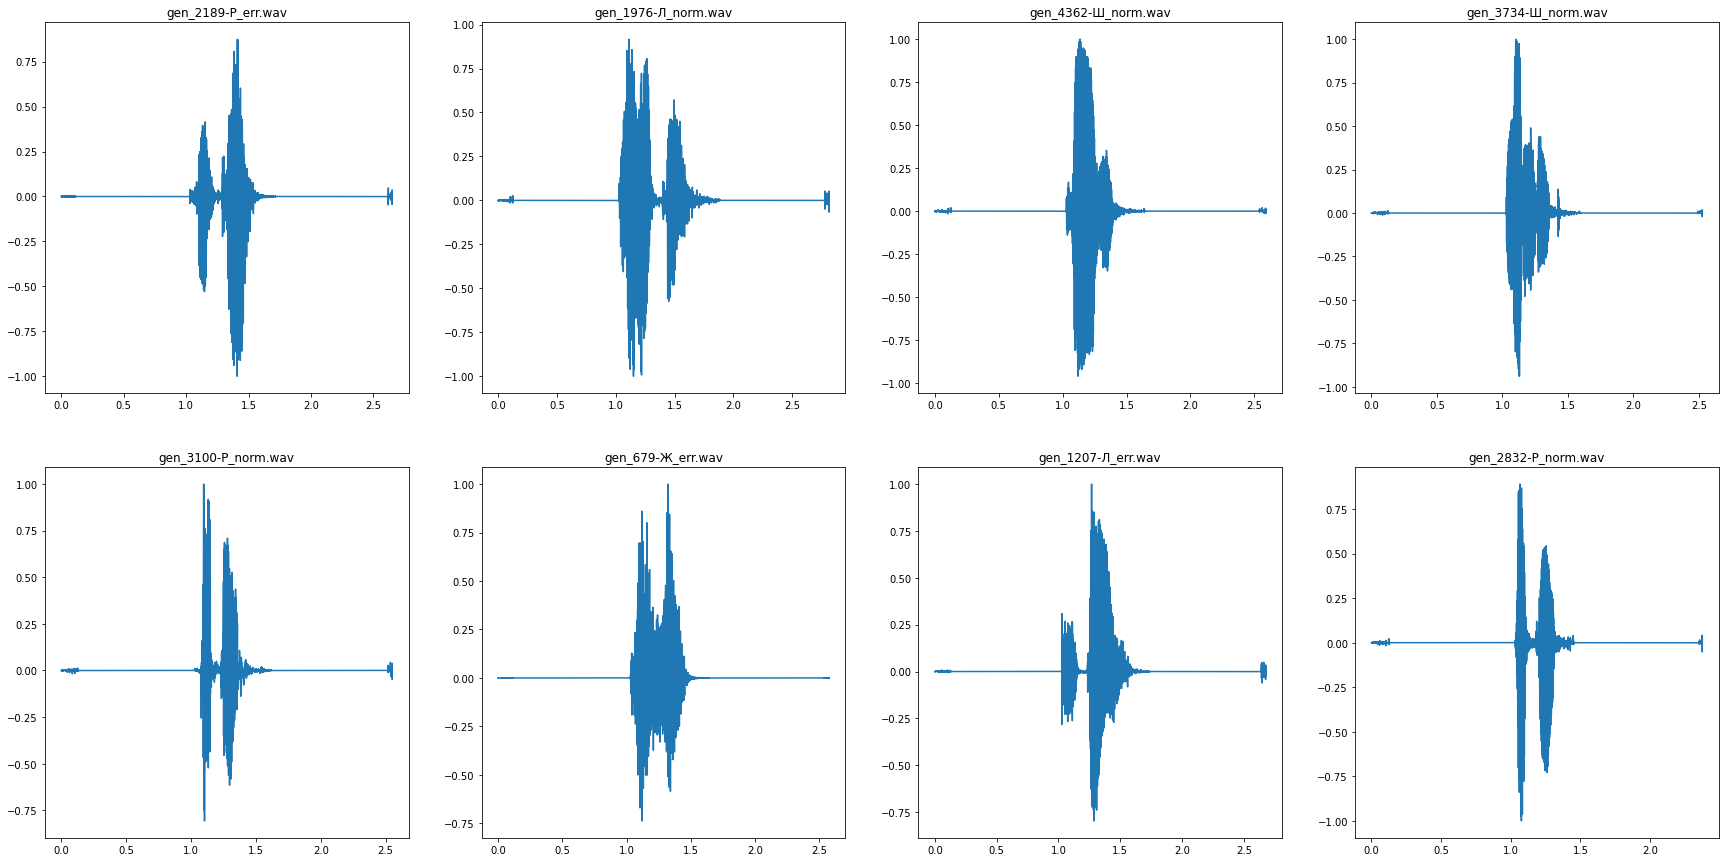

In [92]:
show_diagramm(selectFiles)

#### 3.При необходимости выполнить преобразование данных. Этот этап сильно зависит от типа исследуемых данных и может включать в себя токинизацию и векторизацию текста, извлечение признаков из данных, преобразование изображений в плоский численный массив и другие преобразования.

Для решения текущей задачи, я преобразовываю все полученные волны к одному размеру, а далее получаю MFCC от каждого файла. 

MFCC - это набор признаков для аудио сигналов, полученных из мел-частотных кепстральных коэффициентов (Mel-frequency cepstral coefficients, MFCC).

MFCC используются в аудиообработке и распознавании речи для извлечения важных характеристик звука, которые могут быть использованы в задачах классификации или детекции звуковых событий. Они являются логарифмическими коэффициентами спектра мощности сигнала, которые были преобразованы с помощью косинусного преобразования Фурье (DFT) и мел-шкалы.

Сначала аудио сигнал делится на кадры, затем для каждого кадра вычисляется спектрограмма. Спектрограмма представляет собой график, показывающий какие частоты присутствуют в каждом кадре сигнала. Затем для каждого кадра вычисляется набор MFCC, который содержит информацию о формантах, глоттальных шумах, произносительных характеристиках и других важных особенностях звукового сигнала.

MFCC имеют несколько преимуществ в сравнении с другими методами извлечения признаков, такими как спектральные признаки. Они лучше соответствуют восприятию звука человеком, так как используют мел-шкалу, а не линейную шкалу частот. Они также лучше справляются с шумом и изменениями скорости речи.

Помимо получения MFCC, я также буду увеличивать/уменьшать длинну волны до ~5 секунд, т.к. продолжительность файлов разной длинны и MFCC будет соответственно тоже разной размерности

Ниже представленн пример нескольких файлов в виде MFCC

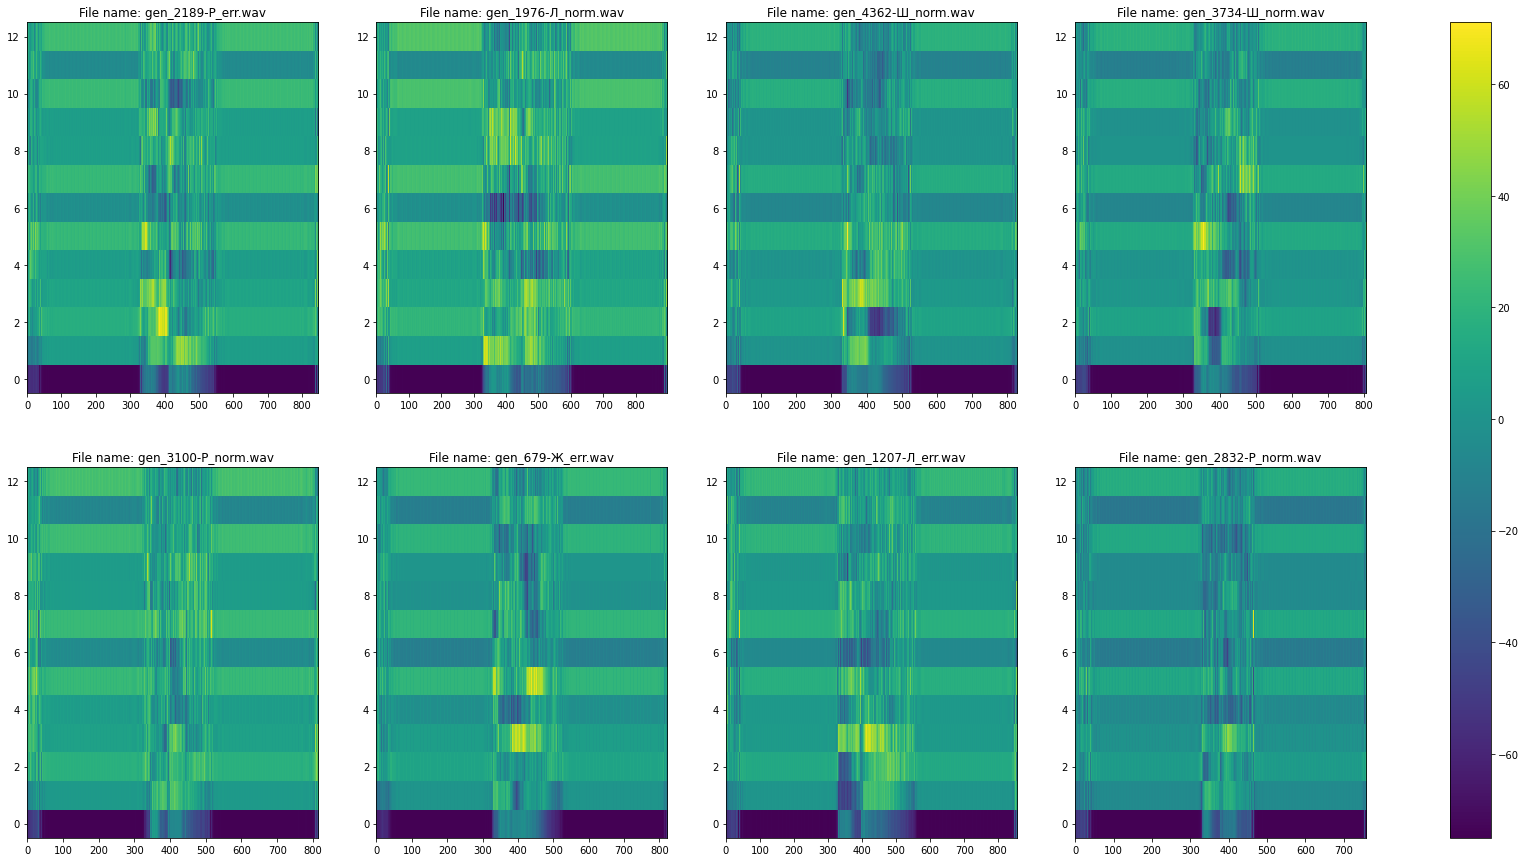

In [93]:
show_spectrs(selectFiles)

#### 4. Разделить набор данных на обучающую, тестовую и валидационную выборки. Обосновать количественные характеристики и метод разделения (временной, случайный, последовательный) выборки.

Данные были сгенерированны в 3 выборки псевдослучаным образом в соотношении 50-25-25.
Под псевдослучайным подразумевается то, что у нас соотношения для каждого звука будут одинаковые, как и соотношения для правильного произношения, но ошибочное произношение включает в себя до 4 вариантов (пример, для слова *стул*: стуй, стув, стуу, стуль) и выбирается ошибка случайным образом, что позволяет адаптировать нейросеть под более реальные данные. В реальности вариаций ошибки в звукопроизношении гораздо больше, были взяты наиболее вероятные.

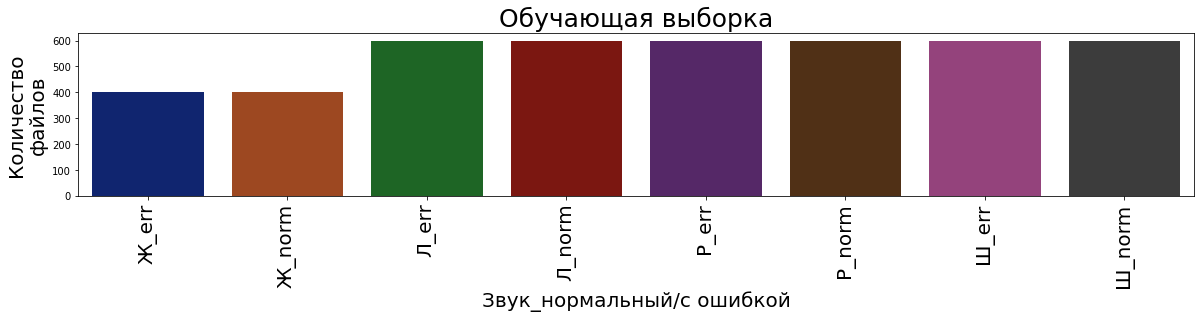

In [94]:
barplot(path_train, title="Обучающая выборка")

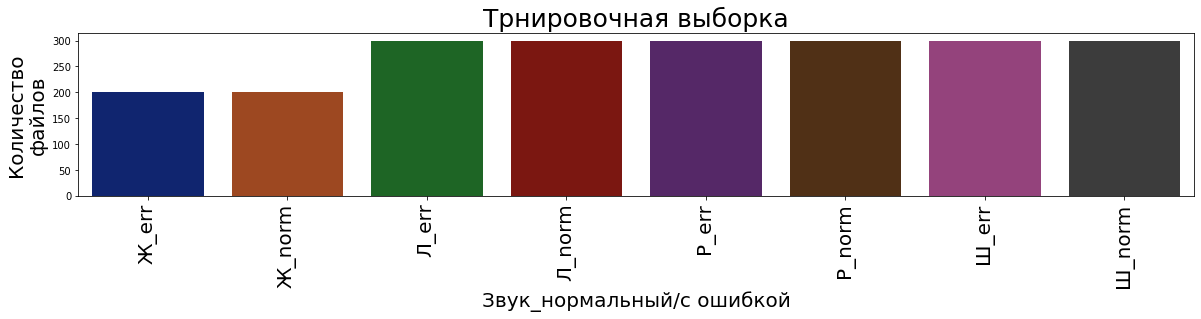

In [95]:
barplot(path_test, title="Трнировочная выборка")

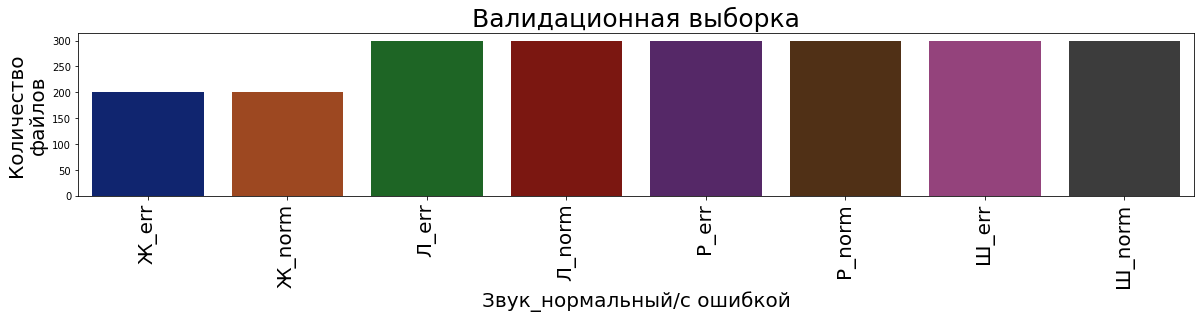

In [96]:
barplot(path_valid, title="Валидационная выборка")

#### 5. Определить принципиальную архитектуру нейросетевой модели глубокого обучения, включая функцию ошибки и методы регуляризации, общую логику обучения модели. Предусмотреть возможные варианты модификации модели.

Архитектура будет включать несколько слоев свертки (определенно эксперементальным способом) с функцией активации ReLU, следующие за ними слои объединения (пулинга) и несколько полносвязных слоев. В качестве функции ошибки используется кросс-энтропию.

Для регуляризации будет использовать *dropout* и *maxpool*, что поможет избежать переобучения модели.

Для обучения можно использовать метод обратного распространения ошибки, используя оптимизаторы, такие как SGD или Adam (в своем примере использую Adam).

Для модификации модели можно попробовать изменять количество слоев свертки, их размеры и количество фильтров, а также изменять количество и размеры полносвязных слоев.

#### 6. Реализовать модель с помощью фреймворка PyTorch. Реализация должна включать функционал загрузки данных, вывода промежуточных и финальных метрик качества и диагностических параметров процесса обучения модели. Реализация должна предусматривать гибкость, позволяющую выполнять ограниченную модификацию модели для выбора наилучшей из альтернативных архитектур.

In [97]:
class CNN_audios(nn.Module):
    def __init__(self):
        super(CNN_audios, self).__init__()
        self.conf1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(5, 11), stride=1, padding=(2, 5)), 
            nn.ReLU(), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        self.conf2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(3 * 366 * 64, 128)
        self.drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 8) 
    
    def forward(self, x):
        x = x.view(-1, 1, 13, 1465)
        x = self.conf1(x)
        x = self.conf2(x)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

#### 7. Настроить параметры входных данных и параметров для обучения. Провести обучение модели на подготовленных входных данных используя выбранные настройки и алгоритмы обучения.

Реализация датасета

In [98]:
class MFCCDataset(Dataset):
    def __init__(self, path):
        # пусть к данным
        self.path = path
        # список файлов
        self.audio_list = os.listdir(path)
        # определяем Encoder для преобразования маркеров к числовым ответам
        self.coder = LabelEncoder()
        # получаем список маркеров
        self.markers_list = self.coder.fit_transform([i.split('-')[-1].replace('.wav', '') for i in self.audio_list])
        # параметры MFCC
        self.params = {
          "channel": 0,
          "dither": 0.0,
          "window_type": "hanning",
          "frame_length": 6.25,
          "frame_shift": 3.125,
          "remove_dc_offset": False,
          "round_to_power_of_two": False,
          "sample_frequency": 48000
        }
    
    def getLabels(self):
        return self.coder.classes_
    
    def getClasses(self):
        return self.markers_list
    
    def getFileNames(self):
        return self.audio_list

    def __len__(self):
        return len(self.audio_list)
    
    def __getitem__(self, idx):
        # получаем путь к файлу
        audio_path = os.path.join(self.path, self.audio_list[idx])
        # получаем wawe, sr ненужен, т.к. он учавствует только в параметрах для получения mfcc и у всех файлов он одинаковый
        wave, _ = torchaudio.load(audio_path)
        # приводим wave к определенному размеру, т.к. длина аудио разная (от 2 до 5 секунд)
        wave = torch.nn.functional.pad(wave, (0, 220000 - wave.size(1)), value=torch.tensor(0.))
        # получаем MFCC
        mfcc = torchaudio.compliance.kaldi.mfcc(wave, **self.params).T
        # достаем маркер
        marker = self.markers_list[idx]
        return mfcc, marker

Определяем датасеты

In [99]:
train_dataset = MFCCDataset(path_train)
test_dataset = MFCCDataset(path_test)
valid_dataset = MFCCDataset(path_valid)

train_loader = DataLoader(train_dataset, batch_size=44, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=22, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=22, shuffle=True)

In [100]:
model = CNN_audios()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [101]:
result = train_model(model, train_loader, valid_loader, optimizer, criterion)

#Эпоха [ 1]: train loss [198.9153], validation loss [186.4550], train accuracy [0.2705], validation accuracy [0.4114]


#Эпоха [ 2]: train loss [183.2450], validation loss [173.9499], train accuracy [0.4498], validation accuracy [0.5577]


#Эпоха [ 3]: train loss [173.5120], validation loss [166.0763], train accuracy [0.5573], validation accuracy [0.6268]


#Эпоха [ 4]: train loss [165.8208], validation loss [159.7048], train accuracy [0.6364], validation accuracy [0.7005]


#Эпоха [ 5]: train loss [160.0151], validation loss [152.0038], train accuracy [0.7045], validation accuracy [0.7914]


#Эпоха [ 6]: train loss [153.1395], validation loss [147.3199], train accuracy [0.7730], validation accuracy [0.8255]


#Эпоха [ 7]: train loss [148.5729], validation loss [145.1677], train accuracy [0.8184], validation accuracy [0.8414]


#Эпоха [ 8]: train loss [145.7051], validation loss [143.4335], train accuracy [0.8448], validation accuracy [0.8573]


#Эпоха [ 9]: train loss [143.0768], validation loss [141.8957], train accuracy [0.8727], validation accuracy [0.8695]


#Эпоха [10]: train loss [141.0648], validation loss [139.9490], train accuracy [0.8889], validation accuracy [0.8914]
Время обучения:  1450.8482768535614 секунд


#### 8. Провести оценку качества модели с использованием предусмотренных метрик качества, проверить модель на переобучение.

Строим графики обучения для 4х метрик и функции ошибки. На них наглядно видно, что модель близится к переобучению, но при этом точность предсказаний валидационной выборки продолжает расти. Для более детального представления необходимо построить тепловую карту. Дальнейшее обучение сети не имеет смысла, она переобучится.
Также на графике precision можно заметить резкое падение валидационной выборки, это связано со звуком Ж, в процессе иследования было выявленно, что правильное определение звука Ж определяется в последнюю очередь. 

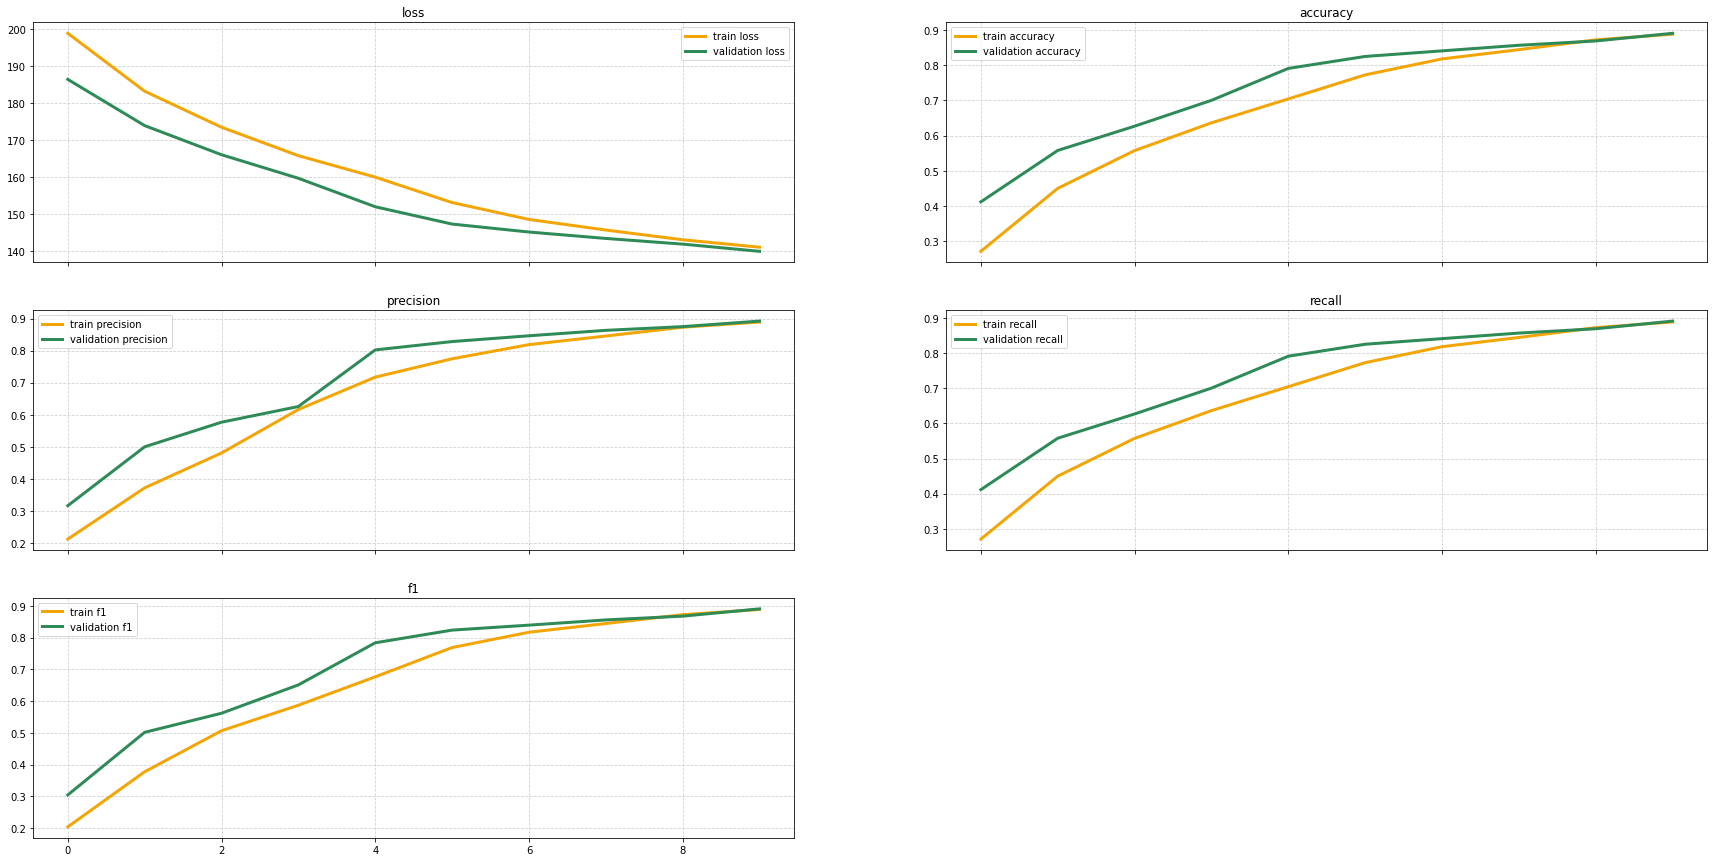

In [102]:
plot_metrics(result, figsize=(30, 15))

Получаем предикты модели по тестовой выборке

In [103]:
y_true, y_pred, loss = test(model, test_loader, criterion)
y_true, y_pred = y_true.cpu(), y_pred.cpu()
metrcis1 = get_metrics(y_true, y_pred)

По показателям наблюдаем низкий показатель recall по звуку **Л с ошибкой**.

In [104]:
print(classification_report(y_true, y_pred, zero_division=0, target_names=test_dataset.getLabels()))

              precision    recall  f1-score   support

       Ж_err       0.98      0.91      0.94       200
      Ж_norm       0.95      0.97      0.96       200
       Л_err       0.86      0.81      0.84       300
      Л_norm       0.89      0.92      0.90       300
       Р_err       0.86      0.84      0.85       300
      Р_norm       0.87      0.90      0.88       300
       Ш_err       0.92      0.90      0.91       300
      Ш_norm       0.92      0.97      0.94       300

    accuracy                           0.90      2200
   macro avg       0.91      0.90      0.90      2200
weighted avg       0.90      0.90      0.90      2200



На тепловой карте мы видим, модель достаточно точно определяет принадлежность слов к звуку.

Около 10% на звуках без ошибки **Л** и **Р** определяется как с ошибкой и по 10% наоборот. Это связано с одним из видов нарушения **искажение**, когда человек пытается произнести звонкий звук, но у него не получается из-за физиологических проблем (плохой тонус мышц, дефект речевого аппарата и т.п.). Не всегда получается правильно определить нарушение в этих звуках, т.к. **искажение** подразумевает подражание, т.е. похожий звук, а на общем уровне мощности это сложно отличить. Данная проблема может быть решена путем увеличения фреймов, получаемых с каждого кадра (MFCC).

Также ошибочный звук **Р** определяется как **Л_norm** и **Л_err**. Тут влияет другой вид нарушения **замена**, т.к. **Р** в основном заменяется на **Л** и сеть делает на этом ошибки.

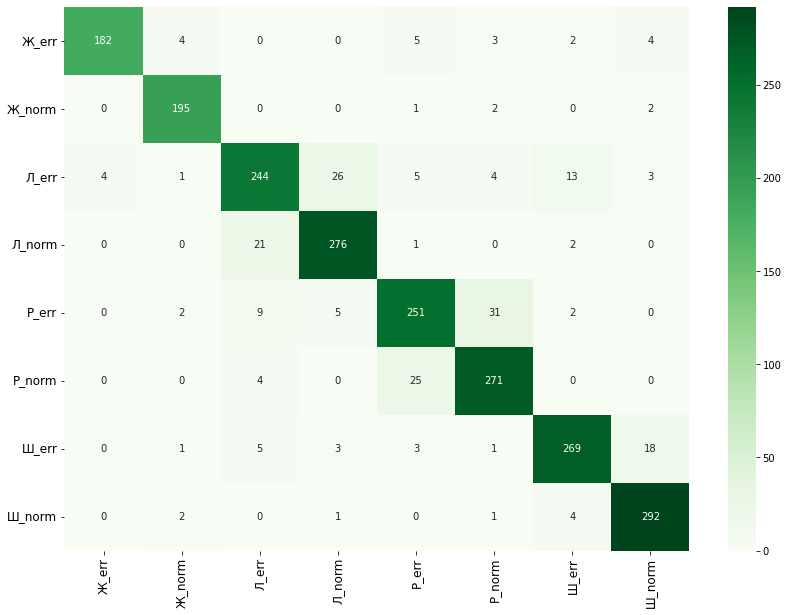

In [105]:
heatmap_(y_true, y_pred, classes=test_dataset.getLabels())

#### 9. Провесит обучение и оценку качества для несколько альтернативных архитектур (вариаций архитектур) моделей (не менее 3) для решения выбранной задачи. Проанализировать результаты, сделать выводы, в том числе определить наилучшую архитектуру.

##### 9.1 Модель_1. Функция активации LeakyReLU.

Одним из недостатков ReLU является возможность появления "мертвых" нейронов, когда активация ReLU становится отрицательной и не может восстановиться в положительном диапазоне. Это приводит к тому, что градиент не может протекать через этот нейрон, что может замедлить обучение и уменьшить точность сети.

LeakyReLU решает эту проблему, добавляя небольшой наклон в отрицательной области. Таким образом, при использовании LeakyReLU вместо ReLU, нейроны не могут "умереть", что может ускорить обучение и увеличить точность сети.

In [140]:
class CNN_audios_1(nn.Module):
    def __init__(self):
        super(CNN_audios_1, self).__init__()
        self.conf1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(7, 13), stride=1, padding=(3, 6)), 
            nn.LeakyReLU(), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        self.conf2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(), 
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(3 * 366 * 64, 128)
        self.drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 8) 
    
    def forward(self, x):
        x = x.view(-1, 1, 13, 1465)
        x = self.conf1(x)
        x = self.conf2(x)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.drop(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [141]:
model_1 = CNN_audios_1()
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.00005)

In [142]:
result_1 = train_model(model_1, train_loader, valid_loader, optimizer_1, criterion_1)

#Эпоха [ 1]: train loss [202.8651], validation loss [188.8368], train accuracy [0.2277], validation accuracy [0.4055]


#Эпоха [ 2]: train loss [185.9008], validation loss [171.8998], train accuracy [0.4225], validation accuracy [0.5768]


#Эпоха [ 3]: train loss [172.3985], validation loss [165.5697], train accuracy [0.5580], validation accuracy [0.6232]


#Эпоха [ 4]: train loss [162.9975], validation loss [158.4785], train accuracy [0.6580], validation accuracy [0.7050]


#Эпоха [ 5]: train loss [158.3158], validation loss [155.5319], train accuracy [0.7043], validation accuracy [0.7359]


#Эпоха [ 6]: train loss [155.5094], validation loss [154.2536], train accuracy [0.7341], validation accuracy [0.7395]


#Эпоха [ 7]: train loss [152.9970], validation loss [153.0987], train accuracy [0.7570], validation accuracy [0.7509]


#Эпоха [ 8]: train loss [150.9046], validation loss [152.1743], train accuracy [0.7802], validation accuracy [0.7605]


#Эпоха [ 9]: train loss [149.7739], validation loss [151.1402], train accuracy [0.7877], validation accuracy [0.7741]


#Эпоха [10]: train loss [145.7491], validation loss [141.6187], train accuracy [0.8293], validation accuracy [0.8695]
Время обучения:  1683.276208639145 секунд


Изначальной модели потребовалось ~25 минут на обучение и она показала точность в 90% за 10 эпох, при отсутствии явного переобучения.

Текущая модель обучилась за ~28 минут с точностью 87% за 10 эпох, но в какой-то момент она переобучилась.

Модель_1 показывает результаты хуже, не смотря на принятые решения по улучшению точности. На основании представленных данных сложно однозначно определить, переобучилась модель или нет, так как ошибка на тренировочной выборке продолжает снижаться, а на валидационной начинает снижаться только с 8-й эпохи. Однако, увеличение точности на тренировочной выборке и разрыв между тренировочной и валидационной точностями может свидетельствовать о том, что модель начинает переобучаться. Но на 10 эпохе происходит переворот и модель начинает лучше обобщать данные.

Возможно, на 10 эпохе произошло снижение переобучения благодаря dropout. Также, может быть, на 10 эпохе модель была обучена на большем количестве данных или ей были предоставлены лучшие данные, что способствовало улучшению ее обобщающей способности. Еще одна возможность заключается в том, что изменение гиперпараметров модели (например, уменьшение размера сети или скорости обучения) помогло снизить переобучение и улучшить обобщающую способность модели.

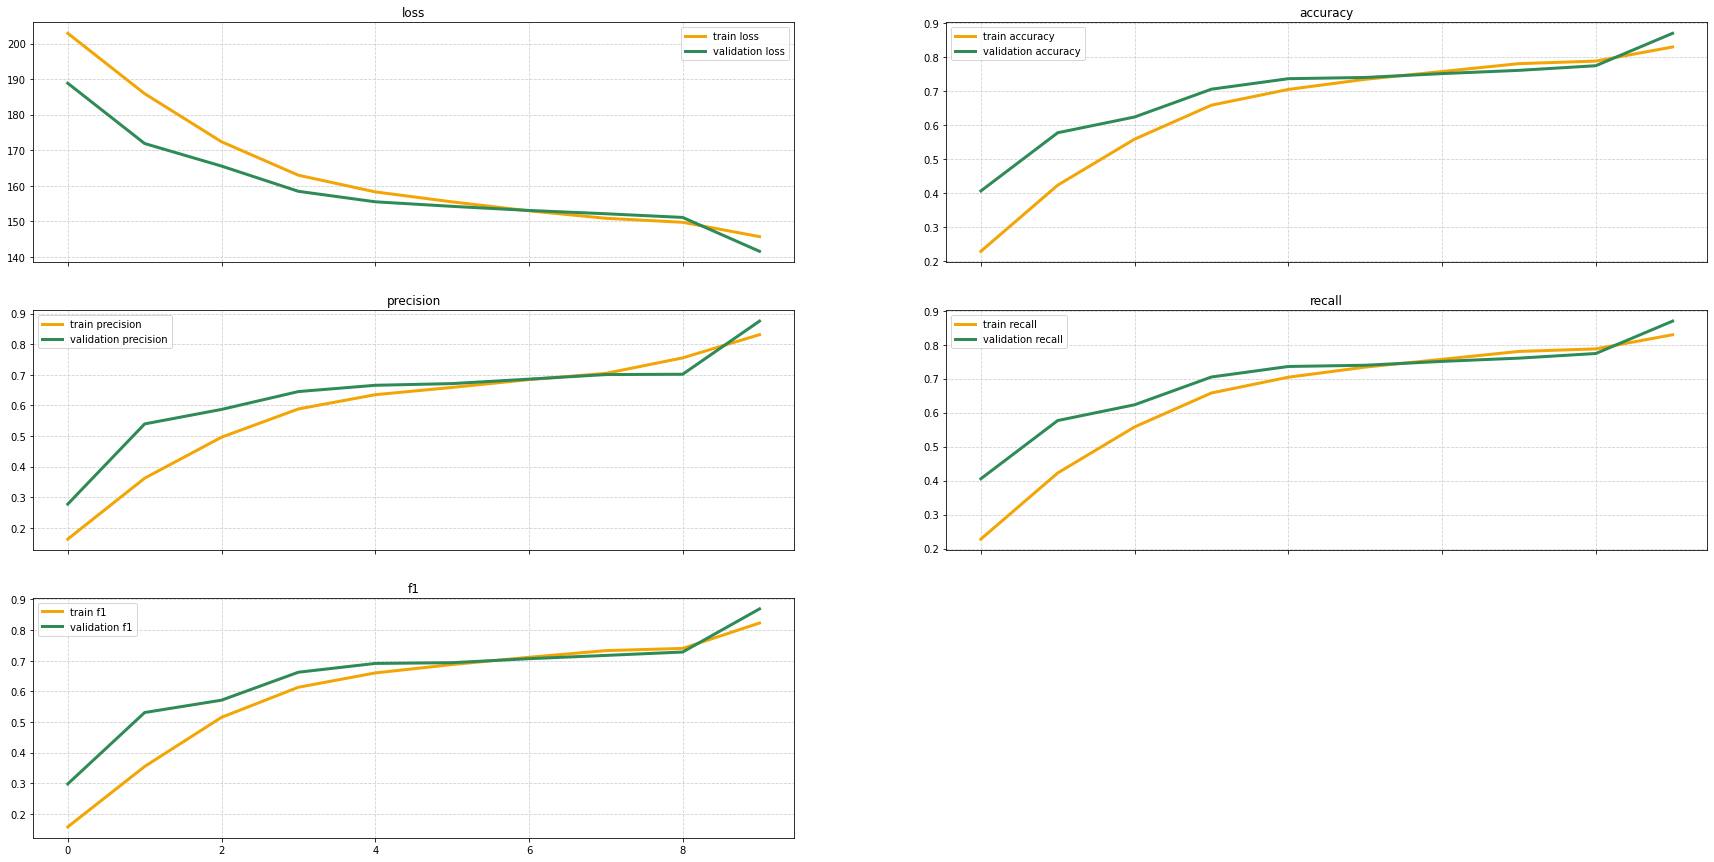

In [143]:
plot_metrics(result_1, figsize=(30, 15))

In [144]:
y_true_1, y_pred_1, loss_1 = test(model_1, test_loader, criterion_1)
y_true_1, y_pred_1 = y_true_1.cpu(), y_pred_1.cpu()
metrcis_1 = get_metrics(y_true_1, y_pred_1)

In [145]:
print(classification_report(y_true_1, y_pred_1, zero_division=0, target_names=test_dataset.getLabels()))

              precision    recall  f1-score   support

       Ж_err       0.98      0.89      0.93       200
      Ж_norm       0.93      0.95      0.94       200
       Л_err       0.83      0.86      0.85       300
      Л_norm       0.88      0.91      0.90       300
       Р_err       0.77      0.89      0.82       300
      Р_norm       0.91      0.78      0.84       300
       Ш_err       0.90      0.79      0.84       300
      Ш_norm       0.83      0.90      0.86       300

    accuracy                           0.87      2200
   macro avg       0.88      0.87      0.87      2200
weighted avg       0.87      0.87      0.87      2200



На тепловой карте мы можем заметить, что в матрицах каждого звука увеличилось количество ответов по побочной диагонали, но при этом уменьшился разброс по другим звука (например Л_err к Ж_err) в сравнении с изначальной моделью.

Мы видим не явное улучшение, модель стала лучше определять принадлежность аудиофайлов к звукам, но в тоже время хуже классифицировать наличие ошибки в этом слове.

Аномально высоким значеним можно отметить Р_norm - Р_err. Как я писал ранее, ошибка в произношении звука Р чаще всего является замена.

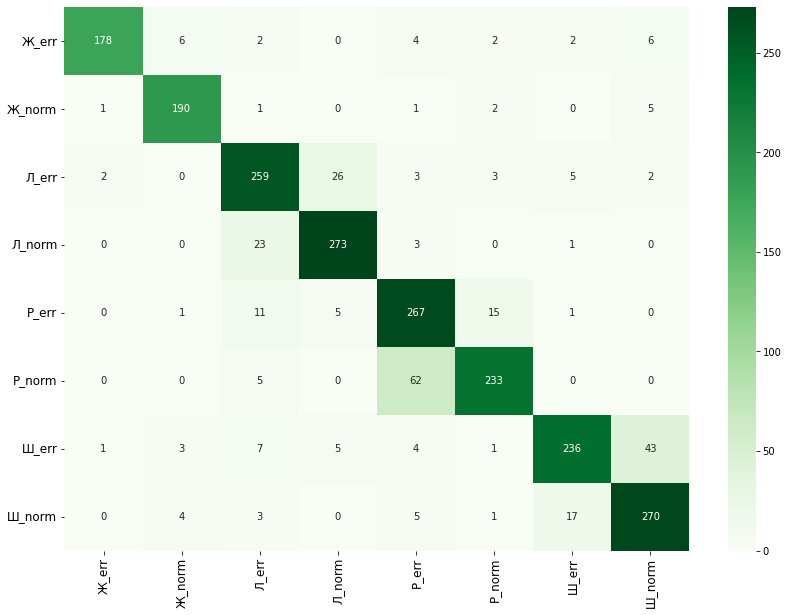

In [146]:
heatmap_(y_true_1, y_pred_1, classes=test_dataset.getLabels())

##### Модель_2. Функция активации LeakyReLU. Изменение kernel_size и padding для 2 счерточного слоя. Увеличение Dropout.

Изменение параметров kernel_size и padding также может повлиять на характеристики сверточных фильтров и на степень сжатия данных во время свертки. 

Более большие значения kernel_size и padding могут привести к большему количеству параметров и более медленному обучению модели. Однако, увеличение kernel_size и padding может улучшить качество выходного изображения, так как это позволяет модели выявлять более сложные и абстрактные признаки.

Увеличение значения dropout помогает снизить переобучение и повысить обобщающую способность модели. Однако, если значение параметра dropout слишком большое, то сеть может начать забывать важную информацию, поскольку многие нейроны будут исключены из обучения. Это может привести к снижению точности модели на тестовых данных.

In [207]:
class CNN_audios_2(nn.Module):
    def __init__(self):
        super(CNN_audios_2, self).__init__()
        self.conf1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(5, 11), stride=1, padding=(2, 5)), 
            nn.LeakyReLU(), # изменение
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        self.conf2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 7), stride=1, padding=(1, 3)), # изменение
            nn.LeakyReLU(), # изменение
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(3 * 366 * 64, 128)
        self.drop = nn.Dropout(p=0.65) # изменение
        self.fc2 = nn.Linear(128, 8) 
    
    def forward(self, x):
        x = x.view(-1, 1, 13, 1465)
        x = self.conf1(x)
        x = self.conf2(x)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = F.leaky_relu(self.fc1(x)) # изменение
        x = self.drop(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

В данном случае, скорость обучения была повышенна в 10 раз, так как модель обучалась достаточно медленно

In [208]:
model_2 = CNN_audios_2()
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.0001)

Чтобы приблизится к результату изначальной модели, потребовалось на 5 эпох больше, что позволило превзойти модель по точности.

За счет повышенного dropout модель стала обучаться медленее, но это позволило увеличить точность на 1% (не слишком большой прирост, относительно времени, которое увеличилось на ~20 минут, и того факта, что пришлось увеличить скорость обучения)

In [209]:
result_2 = train_model(model_2, train_loader, valid_loader, optimizer_2, criterion_2, num_epochs=15)

#Эпоха [ 1]: train loss [205.9062], validation loss [193.7881], train accuracy [0.1989], validation accuracy [0.3309]


#Эпоха [ 2]: train loss [188.2637], validation loss [172.5815], train accuracy [0.3820], validation accuracy [0.5455]


#Эпоха [ 3]: train loss [174.9790], validation loss [160.7643], train accuracy [0.5225], validation accuracy [0.6759]


#Эпоха [ 4]: train loss [165.2462], validation loss [154.7702], train accuracy [0.6266], validation accuracy [0.7305]


#Эпоха [ 5]: train loss [158.8912], validation loss [150.5375], train accuracy [0.6893], validation accuracy [0.7732]


#Эпоха [ 6]: train loss [155.0652], validation loss [148.0714], train accuracy [0.7289], validation accuracy [0.7950]


#Эпоха [ 7]: train loss [150.8687], validation loss [145.9756], train accuracy [0.7709], validation accuracy [0.8136]


#Эпоха [ 8]: train loss [147.4143], validation loss [143.0513], train accuracy [0.8100], validation accuracy [0.8473]


#Эпоха [ 9]: train loss [145.2626], validation loss [140.8644], train accuracy [0.8293], validation accuracy [0.8736]


#Эпоха [10]: train loss [143.7375], validation loss [140.3961], train accuracy [0.8439], validation accuracy [0.8755]


#Эпоха [11]: train loss [141.4373], validation loss [139.2341], train accuracy [0.8709], validation accuracy [0.8864]


#Эпоха [12]: train loss [140.4483], validation loss [138.2460], train accuracy [0.8782], validation accuracy [0.8914]


#Эпоха [13]: train loss [139.6123], validation loss [137.6731], train accuracy [0.8836], validation accuracy [0.8982]


#Эпоха [14]: train loss [137.9692], validation loss [137.1654], train accuracy [0.9050], validation accuracy [0.9055]


#Эпоха [15]: train loss [137.5634], validation loss [136.2210], train accuracy [0.9050], validation accuracy [0.9155]
Время обучения:  2769.3929262161255 секунд


По графику precision мы видим быстрое изменение валидационной выборки на первых 4 эпохах. Падение/рост показателей по всем графикам планый, отколений не наблюдается. Не смотря на то, что ошибка продолжает падать, модель приближается к своему пределу. Дальнейшее обучение не имеет смысла, точность увеличится до -+1% и модель переобучится.

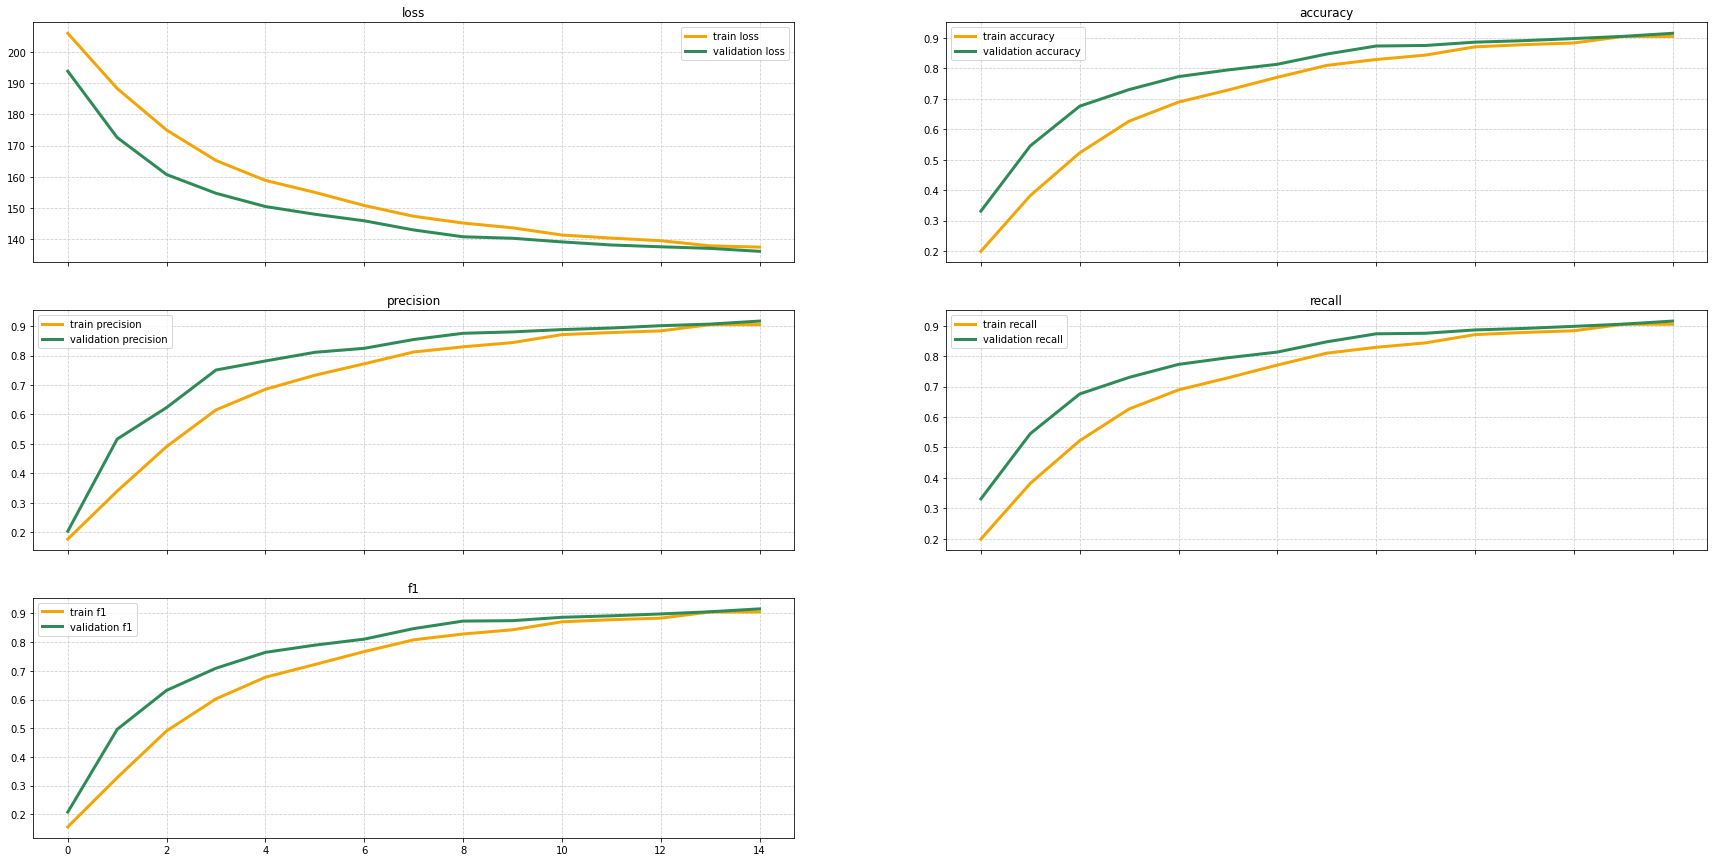

In [210]:
plot_metrics(result_2, figsize=(30, 15))

In [211]:
y_true_2, y_pred_2, loss_2 = test(model_2, test_loader, criterion_2)
y_true_2, y_pred_2 = y_true_2.cpu(), y_pred_2.cpu()
metrcis_2 = get_metrics(y_true_2, y_pred_2)

Сравнивая с изначальной моделью, мы видим, что по всем классам в метрике f1-score показатель увеличился или остался прежним. Но при этом precison и recall отличаю на несколько процентов в + и -.

In [212]:
print(classification_report(y_true_2, y_pred_2, zero_division=0, target_names=test_dataset.getLabels()))

              precision    recall  f1-score   support

       Ж_err       0.98      0.92      0.95       200
      Ж_norm       0.96      0.96      0.96       200
       Л_err       0.83      0.89      0.86       300
      Л_norm       0.92      0.89      0.91       300
       Р_err       0.82      0.89      0.85       300
      Р_norm       0.94      0.87      0.90       300
       Ш_err       0.93      0.93      0.93       300
      Ш_norm       0.96      0.96      0.96       300

    accuracy                           0.91      2200
   macro avg       0.92      0.91      0.92      2200
weighted avg       0.91      0.91      0.91      2200



На тепловой карте мы также видим минимальный разброс по звукам до 10 (исключением является Р_err-Л_err, в этой ситуации я считаю это нормой).

Разброс у звуков Л и Р по побочной диагонали также остался и большая часть сфокусированна на определении нормального звука как ошибочного, в то время как на изначальной модели все было наоборот (что скорее является правильным исходом).

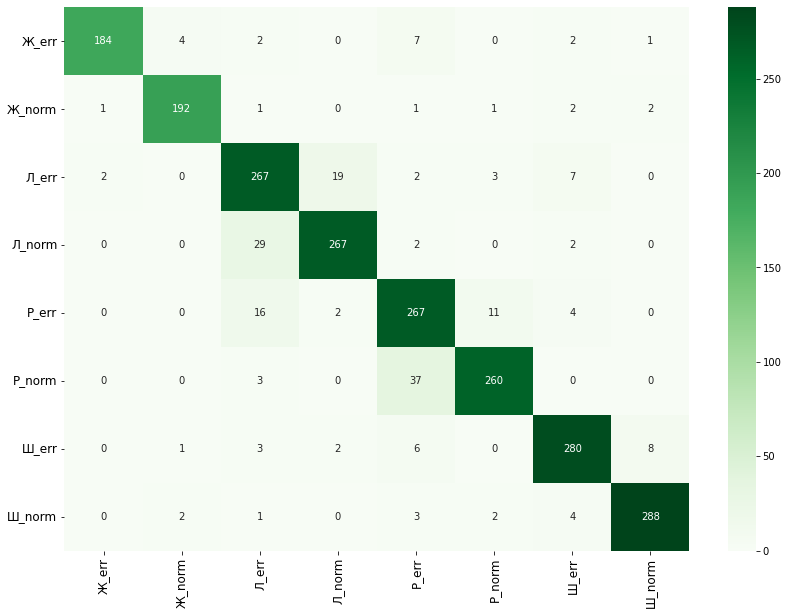

In [213]:
heatmap_(y_true_2, y_pred_2, classes=test_dataset.getLabels())

##### Модель_3. Функция активации LeakyReLU. Уменьшение слоев. Увеличение dropout

Данная модель реализована в сторону упрощения. Убрана последовательность слоев conf2, которая включала в себя сверточный слой, функцию активации, нормализацию батча и пулинг-слой.

Такое изменение может привести к уменьшению количества параметров в модели, что может помочь в борьбе с переобучением при обучении на маленьких датасетах. Однако, это также может уменьшить способность модели изучать более сложные зависимости в данных, что может привести к ухудшению результатов модели.

Кроме того, удаление conf2 и его слоя активации LeakyReLU, может уменьшить способность модели к обнаружению нелинейных зависимостей в данных.

In [225]:
class CNN_audios_3(nn.Module):
    def __init__(self):
        super(CNN_audios_3, self).__init__()
        self.conf1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5, 11), stride=1, padding=(2, 5)), 
            nn.LeakyReLU(), # изменено
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        # self.conf2 = nn.Sequential(
        #     nn.Conv2d(32, 64, kernel_size=(3, 7), stride=1, padding=(1, 3)),
        #     nn.LeakyReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.MaxPool2d(2),
        # )
        self.fc1 = nn.Linear(3 * 366 * 64, 128)
        self.drop = nn.Dropout(p=0.75)
        self.fc2 = nn.Linear(128, 8) 
    
    def forward(self, x):
        x = x.view(-1, 1, 13, 1465)
        x = self.conf1(x)
        # x = self.conf2(x)
        x = self.drop(x) # изменено
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        x = self.drop(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

Скорость обучения также увеличена в 10 раз

In [226]:
model_3 = CNN_audios_2()
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.0001)

In [227]:
result_3 = train_model(model_3, train_loader, valid_loader, optimizer_3, criterion_3, num_epochs=18)

#Эпоха [ 1]: train loss [211.2471], validation loss [212.1053], train accuracy [0.1400], validation accuracy [0.1359]


#Эпоха [ 2]: train loss [200.1671], validation loss [186.9205], train accuracy [0.2570], validation accuracy [0.3895]


#Эпоха [ 3]: train loss [182.0660], validation loss [164.4802], train accuracy [0.4505], validation accuracy [0.6445]


#Эпоха [ 4]: train loss [171.7862], validation loss [158.8023], train accuracy [0.5559], validation accuracy [0.6959]


#Эпоха [ 5]: train loss [162.9810], validation loss [152.8703], train accuracy [0.6511], validation accuracy [0.7514]


#Эпоха [ 6]: train loss [157.4418], validation loss [149.7844], train accuracy [0.7084], validation accuracy [0.7823]


#Эпоха [ 7]: train loss [154.0697], validation loss [146.9186], train accuracy [0.7405], validation accuracy [0.8132]


#Эпоха [ 8]: train loss [149.9651], validation loss [143.3805], train accuracy [0.7859], validation accuracy [0.8468]


#Эпоха [ 9]: train loss [147.4524], validation loss [141.5732], train accuracy [0.8064], validation accuracy [0.8632]


#Эпоха [10]: train loss [145.7235], validation loss [139.7409], train accuracy [0.8266], validation accuracy [0.8836]


#Эпоха [11]: train loss [143.7705], validation loss [139.2326], train accuracy [0.8439], validation accuracy [0.8864]


#Эпоха [12]: train loss [141.5411], validation loss [138.2763], train accuracy [0.8666], validation accuracy [0.8977]


#Эпоха [13]: train loss [140.6226], validation loss [137.7955], train accuracy [0.8766], validation accuracy [0.8977]


#Эпоха [14]: train loss [140.1832], validation loss [137.3469], train accuracy [0.8773], validation accuracy [0.9036]


#Эпоха [15]: train loss [138.5280], validation loss [136.7695], train accuracy [0.8945], validation accuracy [0.9082]


#Эпоха [16]: train loss [138.1018], validation loss [136.6423], train accuracy [0.9002], validation accuracy [0.9095]


#Эпоха [17]: train loss [136.9475], validation loss [135.9996], train accuracy [0.9132], validation accuracy [0.9173]


#Эпоха [18]: train loss [136.9089], validation loss [135.8626], train accuracy [0.9125], validation accuracy [0.9168]
Время обучения:  3230.065983057022 секунд


На графиках мы видим, что первая эпоха прошла не лучшим образом, ошибка валидационной выборки больше чем тренировочной, точность ниже.

Модель тоже дошла до своего предела обучения, это видно по ошибке.

В данном случае мы получили точность еще выше, за счет большего количества эпох и повышенному dropout.

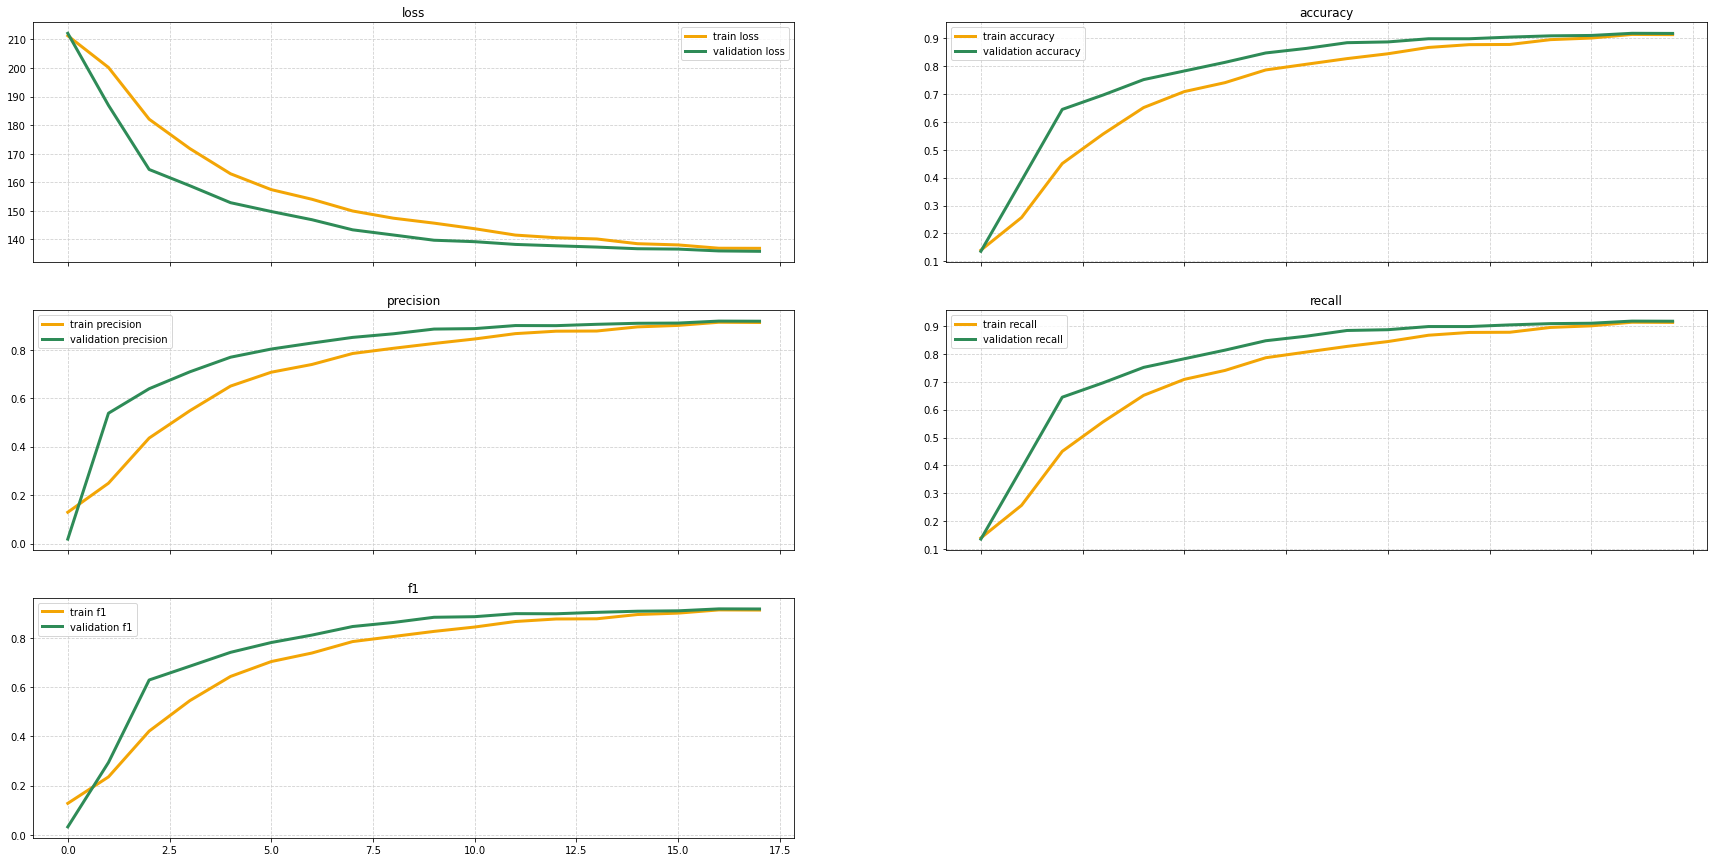

In [228]:
plot_metrics(result_3, figsize=(30, 15))

In [229]:
y_true_3, y_pred_3, loss_3 = test(model_3, test_loader, criterion_3)
y_true_3, y_pred_3 = y_true_3.cpu(), y_pred_3.cpu()
metrcis_3 = get_metrics(y_true_3, y_pred_3)

Явные улучшения наблюдаются в Р_norm (по всем метрикам), recall Л_err, Ж_err.

In [230]:
print(classification_report(y_true_3, y_pred_3, zero_division=0, target_names=test_dataset.getLabels()))

              precision    recall  f1-score   support

       Ж_err       0.99      0.94      0.96       200
      Ж_norm       0.97      0.97      0.97       200
       Л_err       0.86      0.86      0.86       300
      Л_norm       0.90      0.92      0.91       300
       Р_err       0.86      0.86      0.86       300
      Р_norm       0.92      0.91      0.91       300
       Ш_err       0.91      0.92      0.92       300
      Ш_norm       0.95      0.96      0.96       300

    accuracy                           0.91      2200
   macro avg       0.92      0.92      0.92      2200
weighted avg       0.91      0.91      0.91      2200



Сравнивая с первоначальной моделью, можно сказать, что данная модель по всем звукам показывает более высокую точность (если брать матрицу нормального произношения и ошибочного).

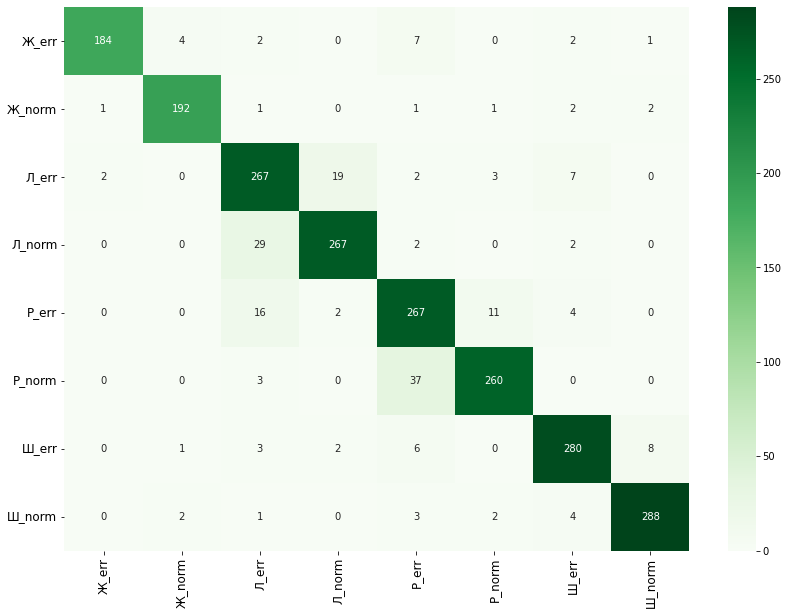

In [231]:
heatmap_(y_true_2, y_pred_2, classes=test_dataset.getLabels())

#### Дополнение. Применение LogisticRegression

LogisticRegression не принимает датасеты, по этому ручной обход

In [120]:
test_X = []
test_y = []
for X_, y_ in test_dataset:
    test_X.append(X_.reshape(-1).numpy())
    test_y.append(y_)

In [121]:
train_X = []
train_y = []
for X_, y_ in train_dataset:
    train_X.append(X_.reshape(-1).numpy())
    train_y.append(y_)

In [122]:
test_X = np.array(test_X)
test_y = np.array(test_y)

train_X = np.array(train_X)
train_y = np.array(train_y)

In [123]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=5000).fit(train_X, train_y)

In [124]:
y_pred = clf.predict(test_X)

In [125]:
print(classification_report(test_y, y_pred, zero_division=0, target_names=test_dataset.getLabels()))

              precision    recall  f1-score   support

       Ж_err       0.90      0.86      0.88       200
      Ж_norm       0.92      0.94      0.93       200
       Л_err       0.76      0.80      0.78       300
      Л_norm       0.86      0.86      0.86       300
       Р_err       0.80      0.79      0.79       300
      Р_norm       0.85      0.81      0.83       300
       Ш_err       0.85      0.85      0.85       300
      Ш_norm       0.88      0.90      0.89       300

    accuracy                           0.85      2200
   macro avg       0.85      0.85      0.85      2200
weighted avg       0.85      0.85      0.85      2200



На графике виден очень большое количество дорожек определилось как Л_err, также видны большие значения по боковым диагоналям.

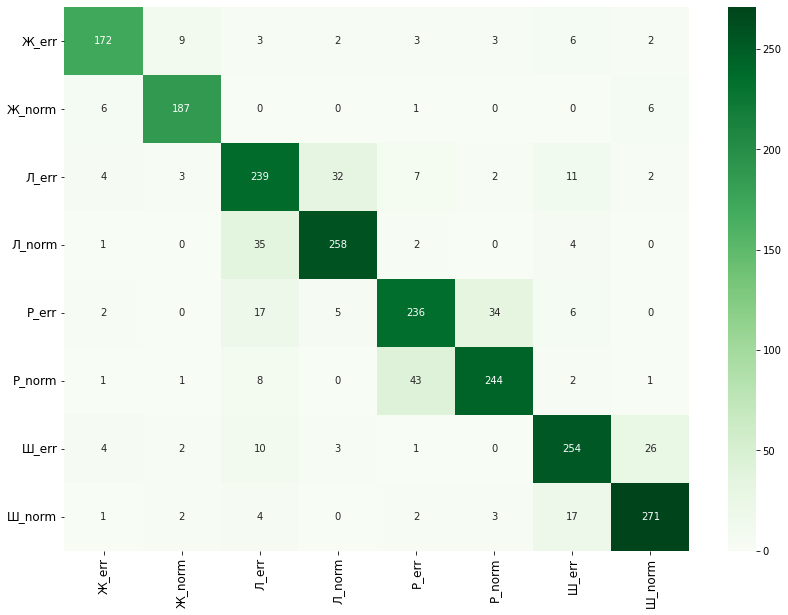

In [126]:
heatmap_(test_y, y_pred, classes=test_dataset.getLabels())